# Classical Shadow Transformer

## Initialization

In [1]:
from CST import *
import matplotlib.pyplot as plt
import pickle
import torch
device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu') # 'cpu', 'cuda', 'mps' ..
print(device)


cuda


## Testing

### Transformer

#### Test 1: Log Probability Estimation

**Goal:** show that the log probability accumulated at sampling is the same as log probability evaluated by the model directly.

Create a model and put into evaluation mode (to disable dropout).

In [2]:
tf = Transformer(outtk_size=2)
tf.eval()
x = torch.tensor([[4],[4],[5],[5],[6],[6]])

In [3]:
y, logprob = tf.sample(x, 1, need_logprob=True)
y, logprob

(tensor([[2],
         [2],
         [2],
         [2],
         [1],
         [2]]),
 tensor([-0.7366, -0.7366, -0.6479, -0.6479, -0.5855, -0.8138]))

In [4]:
tf.logprob(x, y)

tensor([-0.7366, -0.7366, -0.6479, -0.6479, -0.5855, -0.8138],
       grad_fn=<SumBackward1>)

Results are matched up.

#### Test 2: Generative Modeling

**Goal:** test the ability of the transformer model to learn sequence-to-sequence map.

In [5]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])

In [6]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

In [7]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss = -tf.logprob(x, y).mean()
    loss.backward()
    optimizer.step()
    print('{:3d}: {:8.5g}'.format(epoch, loss.item()))

  0:  0.68682
  1:  0.65343
  2:  0.59894
  3:  0.56014
  4:  0.53738
  5:  0.50915
  6:  0.50152
  7:  0.48588
  8:  0.49439
  9:  0.47175


Learns to predict $y$ from $x$.

In [8]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.980307400226593,
 0.019692551344633102,
 0.5630182027816772,
 0.436981737613678,
 0.3444882035255432,
 0.6555117964744568,
 0.6555117964744568]

#### Test 3: VAE loss

**Goal**: test training the transformer with VAE bottleneck

In [9]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])

In [10]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

In [11]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss, logprob, kld = tf.loss(x, y, beta=0.)
    loss.backward()
    optimizer.step()
    print(f'{epoch:3d}: {loss.item():8.5g} {logprob.item():8.5g} {kld.item():8.5g}')

  0:  0.80496 -0.80496   1.0147
  1:   0.6454  -0.6454   1.0182
  2:  0.70382 -0.70382   1.0358
  3:  0.56307 -0.56307   1.0422
  4:  0.55284 -0.55284   1.0461
  5:   0.5539  -0.5539   1.0555
  6:  0.53681 -0.53681   1.0689
  7:  0.46506 -0.46506   1.0881
  8:   0.5448  -0.5448   1.0878
  9:  0.53173 -0.53173   1.1219


Learns to predict $y$ from $x$.

In [12]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.961262583732605,
 0.03873736783862114,
 0.5040262341499329,
 0.49597376585006714,
 0.31608790159225464,
 0.6839120984077454,
 0.6839120388031006]

Now the accuracy can be controlled by the hyperparameter $\beta$.

#### Test 4: Sampling

**Goal**: test sampling and completion.

In [13]:
tf = Transformer(outtk_size=2)
x = torch.randint(4,7,(3,5))
tf.sample(x)

tensor([[1, 1, 2, 2],
        [2, 1, 2, 2],
        [2, 1, 1, 1]])

Completion task.

In [14]:
y = torch.randint(1,3,(3,2))
y

tensor([[1, 2],
        [2, 2],
        [1, 2]])

In [15]:
tf.sample(x, tgt_seq=y)

tensor([[1, 2, 1, 1],
        [2, 2, 1, 1],
        [1, 2, 1, 1]])

### Operator

#### Test 1: Operator Algebra

**Goal:** test operator algebra are correct

In [16]:
ops = [pauli([i]) for i in range(4)]
ops

[I, X, Y, Z]

Multiplication table of Pauli operators

In [17]:
for op1 in ops: 
    for op2 in ops:
        print(f'{op1} @ {op2} = {op1 @ op2}')

I @ I = I
I @ X = X
I @ Y = Y
I @ Z = Z
X @ I = X
X @ X = I
X @ Y = i Z
X @ Z = -i Y
Y @ I = Y
Y @ X = -i Z
Y @ Y = I
Y @ Z = i X
Z @ I = Z
Z @ X = i Y
Z @ Y = -i X
Z @ Z = I


#### Test 2: Operator Gradient

Example: construct an operator

In [18]:
O = pauli('X') + 1j * pauli('Y') - 2 * pauli('Z')
O

X + i Y -2 Z

In [19]:
O = O.requires_grad_()
O

X + i Y -2 Z (requires_grad=True)

In [20]:
O.H @ O

6 I -4 X -2 Z (grad_fn=<class 'IndexBackward0'>)

Operator norm is defined to be $\Vert O\Vert^2=\mathrm{Tr}\,O^\dagger O$

In [21]:
O.norm()

tensor(6., grad_fn=<SelectBackward0>)

In [22]:
O.norm().backward()
O.grad

2 X + (0.00+2.00i) Y -4 Z

### Shadow

#### Test 1: Shadow Evaluate 

**Goal:** evaluate operator expectation value on a shadow dataset.

In [23]:
shd = ghz_shadow(3, 1000)
shd

| -Z +X -Z |
| -X -X +X |
| -Y -Y -Y |
| +X -X -X |
| -Z -X +Y |
| -X -Z +X |
| +Z +Z +Z |
| -X +Y +Z |
| +Y +Z -Y |
| -X +Y -X |
| +X +Y -X |
| +Z -Y -Y |
| -X +X -Y |
| +Y +Z +Z |
| +Z +Z -X |
| -Y -X +Z |
...

In [24]:
pauli('ZZI').expectation(shd)

tensor(0.8550+0.j)

### ClassicalShadowTransformer

#### Test 1: Sampling

**Goal**: test sampling and state reconstruction

In [25]:
cst = ClassicalShadowTransformer(2,0)
cst.sample(6)

| -X -Z |
| +X -X |
| -Z -Z |
| -Y -Y |
| +Z +X |
| -Z -Y |

Reconstruct density operator (matrix).

In [26]:
rho = cst.rho()
rho

1.00 II -0.30 IX -0.25 IY -0.34 IZ -0.36 XI + 0.31 XX + 0.31 XY + 0.36 XZ -0.36 YI + 0.33 YX + 0.28 YY + 0.35 YZ -0.41 ZI + 0.35 ZX + 0.30 ZY + 0.36 ZZ (grad_fn=<class 'SqueezeBackward4'>)

In [27]:
rhomat = rho.matrix_form() / 2**2
rhomat

TypeError: matrix_form() missing 1 required positional argument: 'n_qubit'

In [ ]:
torch.linalg.eigvalsh(rhomat)

tensor([-0.1150,  0.0085,  0.3709,  0.7356], grad_fn=<LinalgEighBackward0>)

#### Test 2: Evaluation

**Goal**: test logprob and loss function evaluation.

In [ ]:
cst = ClassicalShadowTransformer(2,0)
cst.eval()
shd = ghz_shadow(2,10)

In [ ]:
cst.logprob(shd)

tensor([-1.7702, -1.0585, -1.7702, -1.6669, -1.0810, -1.8320, -1.1911, -1.6669,
        -1.2102, -1.7125], grad_fn=<SumBackward1>)

In [ ]:
cst.loss(shd)

(tensor(2.5820, grad_fn=<MeanBackward0>),
 tensor(-1.5054, grad_fn=<MeanBackward0>),
 tensor(1.0766, grad_fn=<MeanBackward0>))

## Training

### Batch Training

Scaning over parameter space and train a collection of models of different number of qubits and hyperparameter $\beta$. `max_steps` - maximal optimization step, `nsr` - the noise signal ratio threshold for the loss function flucturation (optimization stop when the noise signal ratio is larger than this threshold), `window` - the window size used to estimate noise signal ratio (larger window size stricter convergence criterion), `n_sample` - number of classical shadow samples used in each iteration, `lr` -  learning rate.

In [ ]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).to(device).load()
        cst.optimize(1000, max_steps=3000, nsr=16, window=200, n_sample=1000, lr=0.0001)

./model/CST_d64_h16_l1/GHZ_N5_b6


 34%|███▎      | 1009/3000 [09:39<19:02,  1.74it/s]


Inspect loss history to determine convergence.

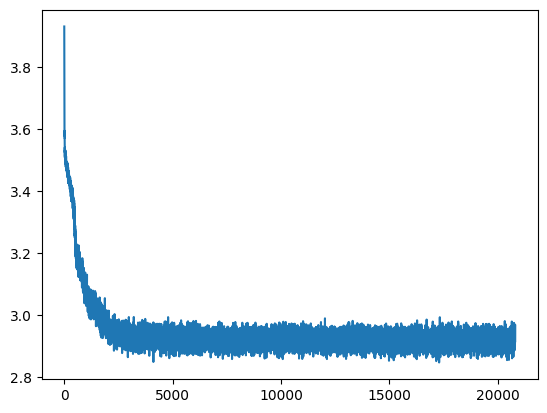

In [ ]:
cst = ClassicalShadowTransformer(5,-4).load()
#print(cst.transformer.repara.logvar)
plt.plot(cst.loss_history)

### Fine Tuning

If necessary, a model can be loaded for fine tuning with smaller training rate to ensure convergence.

In [ ]:
cst = ClassicalShadowTransformer(5, -6).load()

In [ ]:
cst.optimize(1000, max_steps=10000, nsr=32, window=1000, n_sample=1000, lr=0.00001)

./model/CST_d64_h16_l1/GHZ_N5_b-6
531:  2.87878 -2.87629  0.15949 -0.35431


KeyboardInterrupt: 

## Evaluation

### Loss Function History

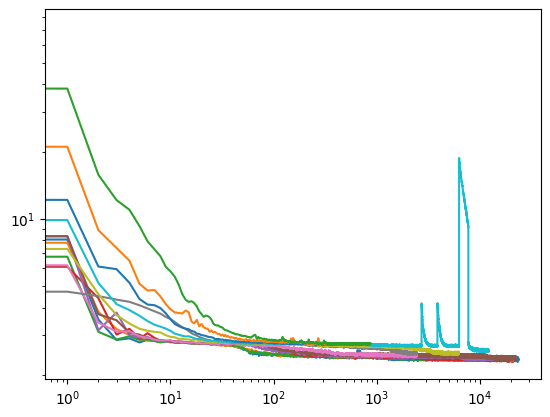

In [ ]:
for logbeta in range(-6,7):
    cst = ClassicalShadowTransformer(4,logbeta).load()
    plt.plot(cst.loss_history)
    plt.yscale('log')
    plt.xscale('log')


### Fidelity and Entropy Map

Compute fidelity and entropy (in unit of bit) of the reconstructed density matrix.

In [32]:
import numpy as np
import gc
data = []
for n_qubit in range(6, 7):
    for logbeta in range(-6, 7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form(n_qubit)/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid = (rho[0,0] + rho[-1,-1] + rho[0,-1] + rho[-1,0])/2
        fid = fid.real.item()
        vals = np.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -np.log2(vals).dot(vals).item()
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, logbeta, fid, ent])
        gc.collect()



c:\Users\Kiki\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._native_multi_head_attention(


KeyboardInterrupt: 

In [ ]:
import time

# Record the start time
data = []

for n_qubit in range(6, 7):
    for logbeta in range(-6, 7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form()/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid = (rho[0,0] + rho[-1,-1] + rho[0,-1] + rho[-1,0])/2
        fid = fid.real.item()
        start_time = time.time()
        vals = torch.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -torch.log2(vals).dot(vals).item()
        end_time = time.time()
        print(end_time-start_time,'s')
        #clear_output(wait=True)
        #print(cst.path + '/' + cst.file)
        #print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, logbeta, fid, ent])

KeyboardInterrupt: 

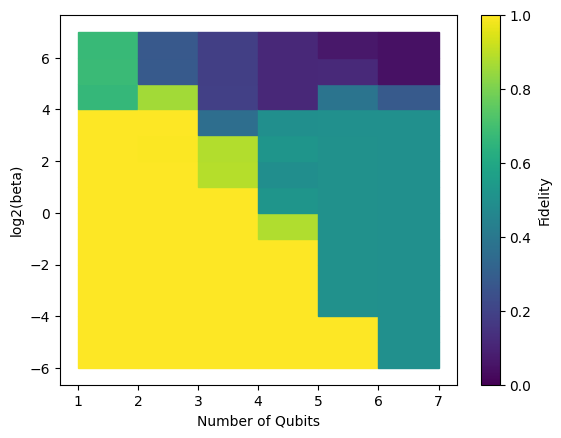

In [ ]:
import numpy as np

x, y, z, _ = np.array(data).T
square_size = 1.0

fig, ax = plt.subplots()

for x, y, z in zip(x, y, z):
    square = plt.Rectangle((x, y), square_size, square_size, color=plt.cm.viridis(z))
    ax.add_patch(square)


sc = plt.scatter([], [], c=[], cmap='viridis', s=100)
plt.colorbar(sc, label='Fidelity')
ax.set_xlabel('Number of Qubits')
ax.set_ylabel('log2(beta)')
plt.show()

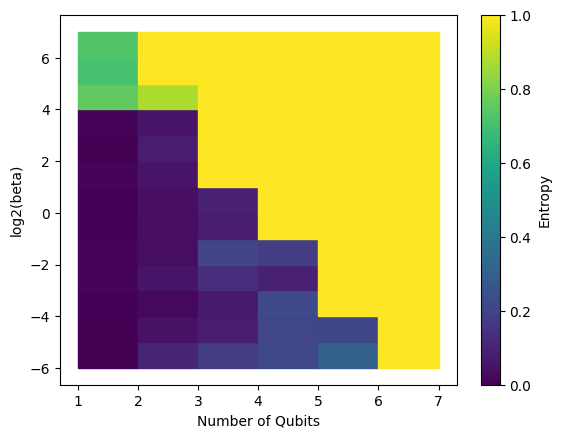

In [ ]:
import numpy as np

x, y, _, z = np.array(data).T
square_size = 1.0

fig, ax = plt.subplots()

for x, y, z in zip(x, y, z):
    square = plt.Rectangle((x, y), square_size, square_size, color=plt.cm.viridis(z))
    ax.add_patch(square)


sc = plt.scatter([], [], c=[], cmap='viridis', s=100)
plt.colorbar(sc, label='Entropy')
ax.set_xlabel('Number of Qubits')
ax.set_ylabel('log2(beta)')
plt.show()

In [ ]:

fig, ax = plt.subplots()

for x, y, z in zip(x, y, z):
    square = plt.Rectangle((x - square_size / 2, y - square_size / 2), square_size, square_size, color=plt.cm.viridis(z))
    ax.add_patch(square)


sc = plt.scatter([], [], c=[], cmap='viridis', s=100)
plt.colorbar(sc, label='Fidelity')
ax.set_xlabel('Number of Qubits')
ax.set_ylabel('log2(beta)')
plt.show()

In [ ]:
with open('./data/map.dat', 'wb') as f:
    pickle.dump(data, f)

Fidelity for 6 qubits (and beyond) can only be estimated by classical shadow tomography. First, prepare the GHZ state density matrix and convert it to Operator class.

In [ ]:
rho = qst.ghz_state(6).density_matrix
tok = rho.tokenize()
paulis = tok[:,:-1]
coeffs = (9.-2.*tok[:,-1]) * rho.cs
rho = Operator(torch.tensor(paulis), torch.tensor(coeffs))

Then evaluate the expectation value of the density matrix on the classical shadow ensemble.

In [ ]:
#data = []
for logbeta in range(2, 7):
    cst = ClassicalShadowTransformer(6, logbeta, embed_dim=128, n_layers=2).load().eval();
    clear_output(wait=True)
    print(cst.path + '/' + cst.file)
    fids = []
    for _ in range(5):
        shd = cst.sample(100000)
        fid = rho.expectation(shd, batch_size=1000).real.item()
        print(f'F = {fid:8.5f}')
        fids.append(fid)
    data.append([6, logbeta, fids])

./model/CST_d128_h16_l2/GHZ_N6_b6
F =  0.07216
F =  0.06822
F =  0.05655
F =  0.07230
F =  0.08284


In [ ]:
with open('./data/fid6_d128_l2.dat', 'wb') as f:
    pickle.dump(data, f)

### Atlas Boreas Cygnus

Take three representative models.

In [ ]:
mdls = {
    'atlas': ClassicalShadowTransformer(5, -5).load().eval(),
    'boreas': ClassicalShadowTransformer(5, -1).load().eval(),
    'cygnus': ClassicalShadowTransformer(5, 6).load().eval()}

Chat with the model. Dictionary:

| Number | Symbol |
|--------|--------|
| `1`    | `+`    |
| `2`    | `-`    |
| `3`    | `I`    |
| `4`    | `X`    |
| `5`    | `Y`    |
| `6`    | `Z`    |

* Z-test: `x: ZZZZZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* X-test: `x: XXXXX, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* XZ-test: `x: XXXXZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 

Collect data:

In [ ]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/z_test.dat', 'wb') as f:
    pickle.dump(data, f)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 3 for tensor number 1 in the list.

In [ ]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/x_test.dat', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
x[:,-1] = 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/xz_test.dat', 'wb') as f:
    pickle.dump(data, f)

### Density Matrix Reconstruction

Reconstruct density matrices for representative models.

In [ ]:
data = {}
for name, mdl in mdls.items():
    with torch.no_grad():
        rho = mdl.rho().matrix_form()/2**mdl.n_qubit # reconstruction
    data[name] = rho.tolist()
with open('./data/rhos.dat', 'wb') as f:
    pickle.dump(data, f)

### Latent Space Structure

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(2)
x = torch.cartesian_prod(*[torch.tensor([4,5,6])]*5)
data = {'x': (x-3).tolist()}
for name, mdl in mdls.items():
    with torch.no_grad():
        src = mdl.transformer.embed(x)
        mem = mdl.transformer.encode(src)
    mem = mem.view(mem.shape[0],-1)
    z = tsne.fit_transform(mem)
    data[name] = z.tolist()
with open('./data/z_embed.dat', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
import numpy as np

# Create two 4x4 NumPy arrays
array1 = np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12],
                   [13, 14, 15, 16]])

array2 = np.array([[10, 20, 30, 40],
                   [50, 60, 70, 80],
                   [90, 100, 110, 120],
                   [130, 140, 150, 160]])
c=[1]
# Add the arrays element-wise
result = array1 + c * array2

# Print the result
print(result)


[[ 11  22  33  44]
 [ 55  66  77  88]
 [ 99 110 121 132]
 [143 154 165 176]]


In [31]:
import gc
gc.collect()

4258